In [18]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils.read_files import read_from_control, make_default_path

In [50]:
# Store the name of the 'active' file in a variable
basin = "TuolumneRiver"
controlFile = f"control_{basin}.txt"

In [51]:
# Find the file path for the basin boundary
basinPath = read_from_control(controlFile, "catchment_shp_path")
basinName = f"{basin}.shp"
# Specify the default path if required
if basinPath == 'default':
    basinPath = make_default_path('shapefiles/catchment', controlFile)
else: 
    basinPath = Path(basinPath) # ensure Path() object is created

In [52]:
# open one of the gridmet files to reproject to
gridmetPath = f"/storage/dlhogan/summa_modeling_data/domain_{basin}/forcing/1_raw_data/"
gridmetFile = "gridmet_pr.nc"

gridmet = xr.open_dataset(gridmetPath + gridmetFile)
gridmet_value = gridmet['precipitation_amount'].rio.write_crs(gridmet['crs'].attrs['crs_wkt'])

In [53]:
# find the location of the gridmet elevation data
gridmetElevFile = Path('/storage/dlhogan/summa_modeling_data/gridmet_metdata_elevationdata.nc')

In [54]:
# Find file path
geoPath = read_from_control(controlFile,'forcing_geo_path')
geoName = 'gridmet_dem.nc'
# Specify the default path if required
if geoPath == 'default':
    geoPath = make_default_path('forcing/0_geopotential', controlFile)
else: 
    geoPath = Path(geoPath) # ensure Path() object 

In [55]:
# open the basin shapefile
basin_shp = gpd.read_file(basinPath / basinName)

# open the gridmet elevation data
gridmet_elevation = xr.open_dataset(gridmetElevFile)['elevation']
# add the basin_shp crs to gridmet_elevation
gridmet_elevation = gridmet_elevation.rio.write_crs(basin_shp.crs)

# reproject to match the input data
gridmet_elevation = gridmet_elevation.rio.reproject_match(gridmet_value)

In [56]:
basin_gridmet_elevation = gridmet_elevation.rio.clip_box(*basin_shp.total_bounds)

In [57]:
# save to geoPath
basin_gridmet_elevation.to_netcdf(geoPath / geoName)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

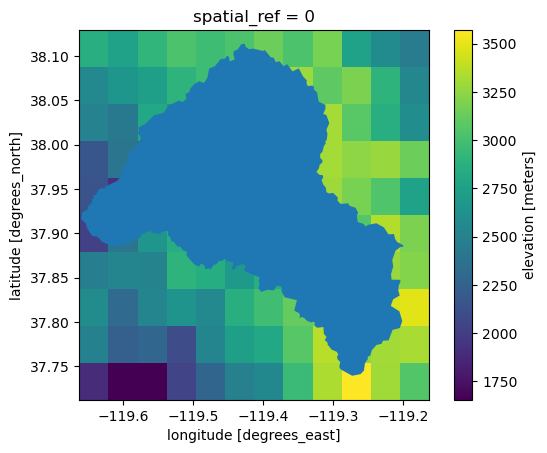

In [58]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
basin_gridmet_elevation.plot(ax=ax)
basin_shp.plot(ax=ax)